# Learning Limit Order Book Dynamics with NSPDE.

In this notebook we train the NSPDE model by minimising an expected signature kernel score to learn limit order book dynamics.

### Imports

In [1]:
import torch
import os
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from src.gan.discriminators_spde import SigKerMMDDiscriminator, ExpectedSigKerScoreDiscriminator
from src.gan.generators_spde import Generator
from src.gan.output_functions import plot_loss
from src.gan.base import stopping_criterion
from statsmodels.tsa.stattools import acf
from src.evaluation import generate_ks_results_nspde
from src.utils.helper_functions.global_helper_functions import get_project_root

In [2]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

## 1. Get data

In [3]:
data = np.load(get_project_root().as_posix() + '/data/lob_neurips.npy')
data = torch.tensor(data)

In [4]:
data.shape

torch.Size([11325, 32, 20, 1])

In [5]:
dim_x = 20
dim_t = 32
output_dim = 1

In [6]:
gridT = torch.linspace(0,1,dim_t).repeat(dim_x,1)
gridX = torch.linspace(0,1,dim_x).unsqueeze(-1).repeat(1,dim_t)

grid = torch.stack([gridX, gridT], dim=-1).to(device)

In [7]:
grid.shape

torch.Size([20, 32, 2])

## 2. Begin training

In this section we set the training parameters for the GAN. Each parameter is annotated.

In [8]:
# Generator arguments
dim = 1
initial_noise_size = 1              # How many noise dimensions to sample at the start of the SDE.
noise_size         = 2              # How many dimensions the Wiener process motion has.
hidden_size        = 16             # How big the hidden state of the generator NSPDE is.
noise_type         = "white"        # Noise type argument for torchspde
integration_method = "fixed_point"  # Integration method to solve the latent SPDE
fixed              = True           # Whether to fix the starting point or not
data_size          = data.shape[-1]
modes1             = 10             # Number of modes to perform convolution in the temporal dimension
modes2             = 20             # Number of modes to perform convolution in the spatial dimension
n_iter             = 4              # Number of iterations to solve the fixed point problem (if integration_method is "fixed_point")

# Discriminator args
dyadic_order   = 1                  # Mesh size of PDE solver used in loss function
kernel         = "rbf_id"           # Type of kernel to use in the discriminator
use_phi_kernel = False              # Whether we want to take averages of signature kernels 
n_scalings     = 3                  # Number of kernels to average
sigma         = {'sigma':10}        # hyperparameters of the kernel
adversarial   = False               # Whether to adversarially train the discriminator or not.
max_batch     = 32                  # Maximum batch size to pass through the discriminator.
loss_evals    = 1                   # Number of evaluations before doing gradient step

if not adversarial:
    discriminator_type = "scoring"
else:
    discriminator_type = "mmd"

# Training hyperparameters
generator_lr     = 1e-03         # Generator initial learning rate
generator_mom    = 0.            # (Optional) momentum parameter for generator
discriminator_lr = 3e-03         # Discriminator initial learning rate
disriminator_mom = 0.            # (Optional) momentum parameter for discriminator
batch_size       = 32            # Batch size (set above in the data extraction)
steps            = 2000          # How many steps to train both generator and discriminator for.
gen_optim        = "Adam"        # Optimiser for generator

weight_decay     = 5*1e-04       # Weight decay.
disc_optim       = "Adam"        # Optimiser for discriminator

# Evaluation and plotting hyperparameters
steps_per_print  = 50             # How often to print the loss.
update_freq  = 50

In [9]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
infinite_train_dataloader = (elem for it in iter(lambda: dataloader, None) for elem in it)

## 2.2 Init Generator

In [10]:
# create correlation function for the noise in input to the generator
def my_smooth_corr(x, a, r = 2):
    my_eps=0.001
    j = 1.*torch.arange(1,x.shape[0]+1).to(x.device)
    j[-1] = 0.
    q = j**(-(2*r+1+my_eps)/2)
    q[-1]=0
    res = torch.sqrt(q)*torch.sqrt(2. / a) * torch.sin(j * torch.pi * x / a)
    return res

if noise_type[0] == 'r':
    input_roughness = int(noise_type.split('_')[-1])
    noise_type = lambda x,a : my_smooth_corr(x, a, r = input_roughness)
# Initialise the generator
generator = Generator(
    dim=dim,
    data_size=output_dim, 
    initial_noise_size=initial_noise_size,
    noise_size=noise_size, 
    hidden_size=hidden_size, 
    initial_point='given',
    noise_type=noise_type,
    integration_method=integration_method,
    modes1=modes1, 
    modes2=modes2,
    n_iter=n_iter,
).to(device)

## 2.3 Init Discriminator

In [11]:
# Initialise the discriminator
if discriminator_type.lower() == "scoring":
    discriminator = ExpectedSigKerScoreDiscriminator(
        kernel_type = kernel,
        dyadic_order = dyadic_order,
        sigma=sigma,
        path_dim = output_dim,
        adversarial=adversarial,
        max_batch=max_batch,
        use_phi_kernel = use_phi_kernel,
        n_scalings = n_scalings
    ).to(device)
else:
    discriminator = SigKerMMDDiscriminator(
        kernel_type=kernel, 
        dyadic_order=dyadic_order, 
        path_dim=output_dim, 
        sigma=sigma,
        adversarial=adversarial,
        max_batch=max_batch
    ).to(device)
    
mmd = SigKerMMDDiscriminator(
        kernel_type = kernel,
        dyadic_order = dyadic_order,
        sigma=sigma,
        path_dim = output_dim,
        adversarial=adversarial,
        max_batch=max_batch,
        use_phi_kernel = use_phi_kernel,
        n_scalings = n_scalings
    ).to(device)

## 3. Train the NSPDE

In [12]:
generator_optimiser = torch.optim.Adam(generator.parameters(), lr=generator_lr)#, weight_decay=weight_decay)

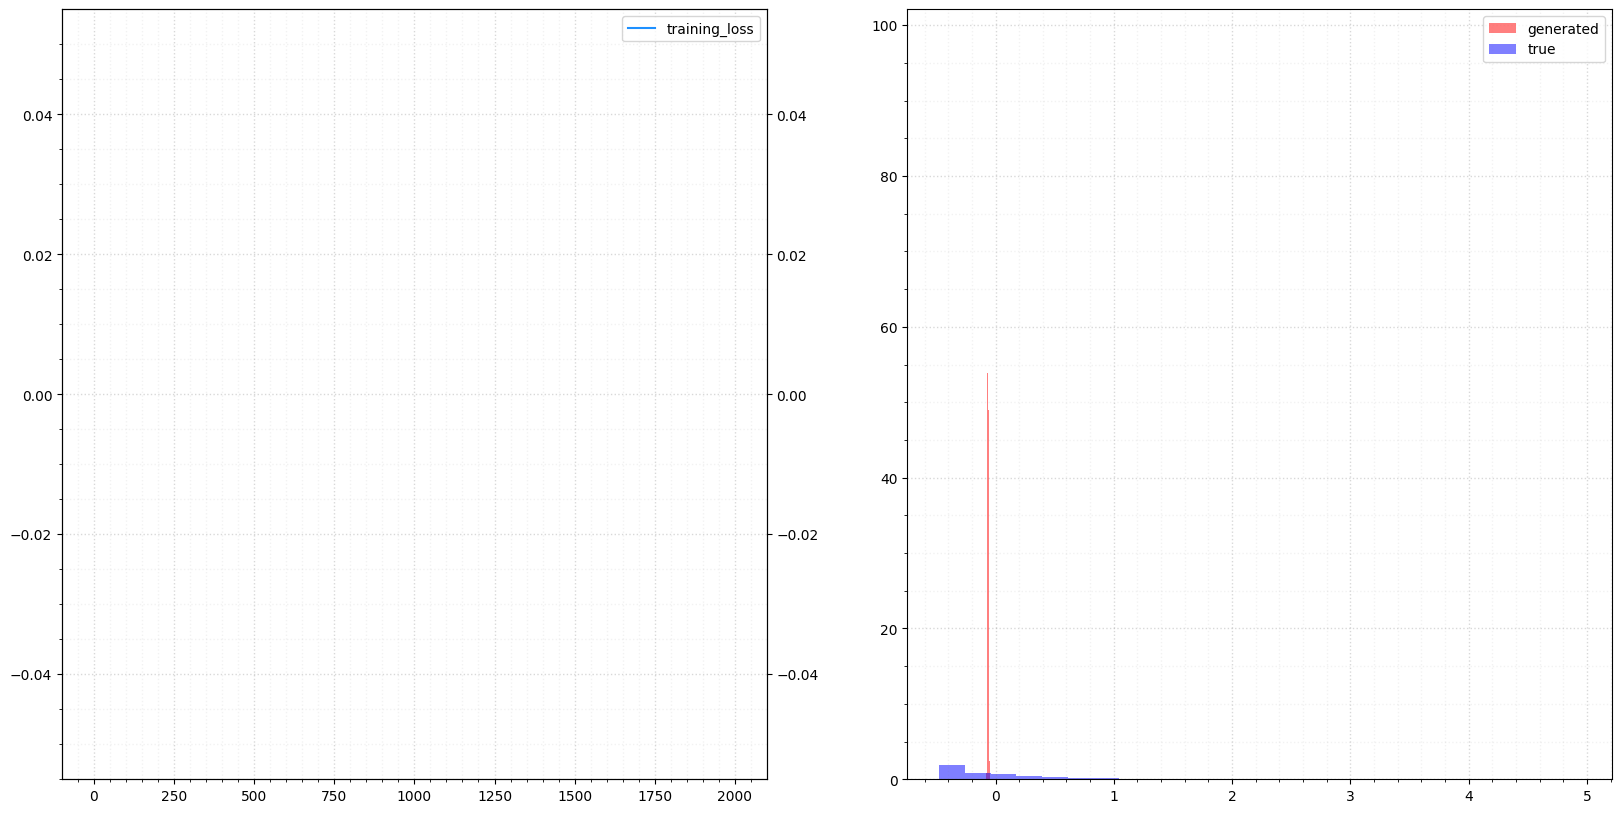

  0%|          | 1/2000 [00:13<7:22:50, 13.29s/it]

Step:   0 Total loss (unaveraged): -1.05850e+00 K-S passed: 0.0 


  1%|          | 22/2000 [00:18<28:01,  1.18it/s] 


KeyboardInterrupt: 

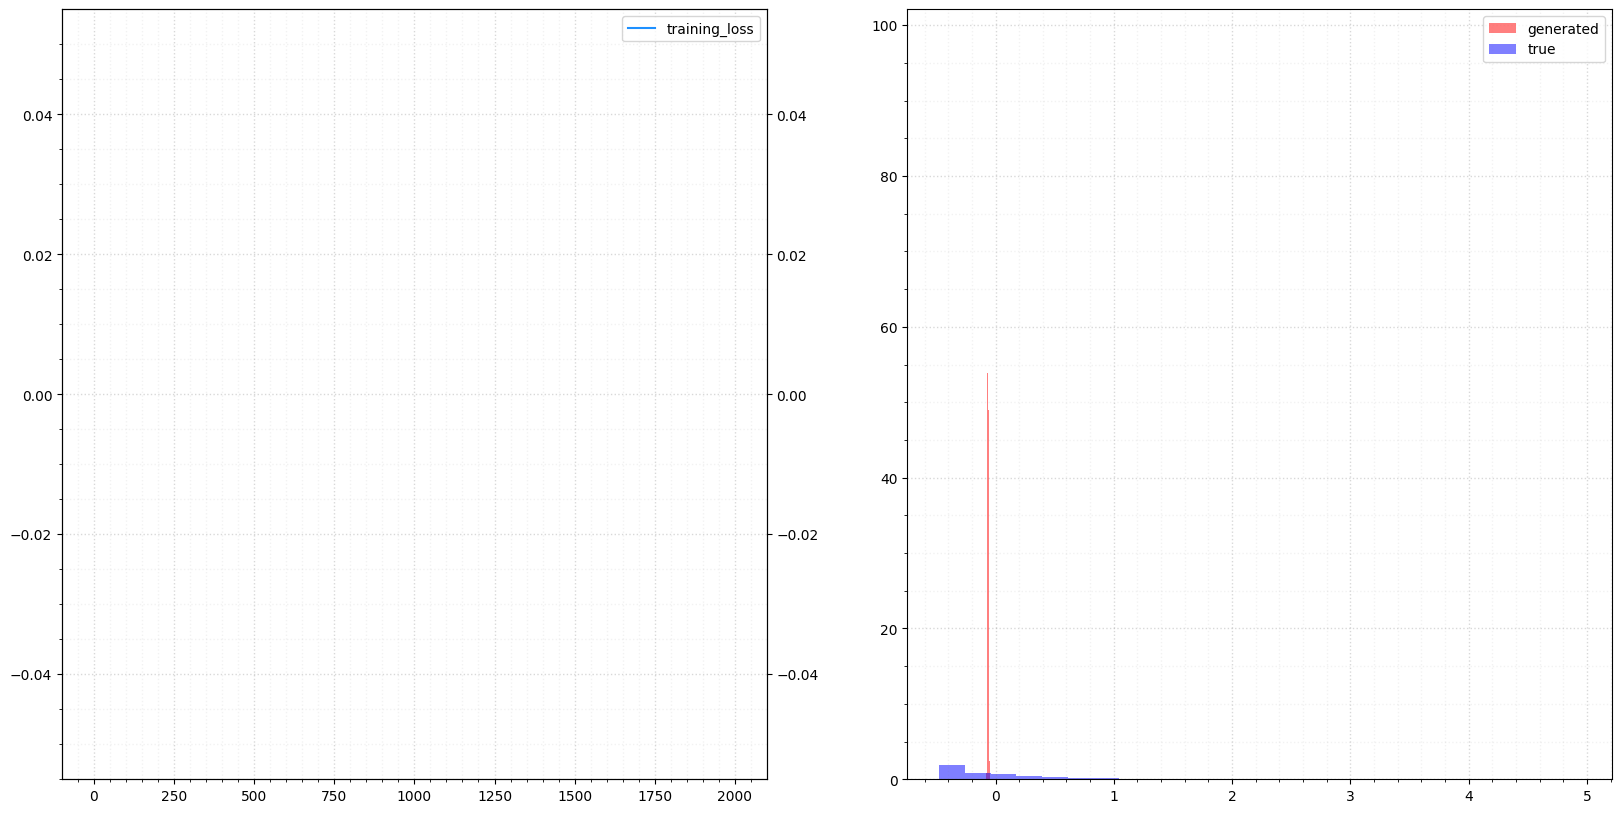

In [13]:
alpha = .1
tr_loss = torch.zeros(steps, requires_grad=False).to(device)
sigmas = torch.zeros(steps, requires_grad=False).to(device)
step_vec = np.arange(steps)
trange = tqdm(range(steps), position=0, leave=True)

for step in trange:

    loss = 0
    for _ in range(loss_evals):
        real_samples      = next(infinite_train_dataloader)
        
        if real_samples.shape[0]!=batch_size:
            real_samples      = next(infinite_train_dataloader)
        
        real_samples = real_samples.to(device)
        u0 = real_samples[:,0,:].permute(0,2,1).float()
        generated_samples = generator(grid, batch_size, u0)
        loss += discriminator(alpha*torch.cumsum(generated_samples,dim=1), alpha*torch.cumsum(real_samples,dim=1).detach())

    loss /= loss_evals
    loss.backward()

    tr_loss[step] = loss.clone()

    generator_optimiser.step()
    generator_optimiser.zero_grad()
    
    if ((step % update_freq == 0) or (step == steps-1)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1_ = ax1.twinx() 
        # Plot updated loss
        with torch.no_grad():
            np_tr_loss = tr_loss.detach().cpu().numpy()
            np_tr_sigma = sigmas.detach().cpu().numpy()

        current_loss = np_tr_loss[:step]
        current_sigma = np_tr_sigma[:step]
        print(current_loss)
        future_loss  = 0. if len(current_loss) == 0 else np.min(current_loss) - np.std(current_loss)
        future_sigma  = 0. if len(current_sigma) == 0 else np.min(current_sigma) - np.std(current_sigma)
        current_steps = step_vec[:step]
        current_sigmas = step_vec[:step]
        future_steps  = step_vec[step:]
        future_loss   = np.array([future_loss for _ in range(future_steps.shape[0])])
        future_sigma   = np.array([future_sigma for _ in range(future_steps.shape[0])])

        ax1.plot(current_steps, current_loss, alpha=1., color="dodgerblue", label="training_loss")
        ax1.plot(future_steps, future_loss, alpha=0.)
        ax1_.plot(current_steps, current_sigma, alpha=1., color="red", label="sigma")
        ax1_.plot(future_steps, future_sigma, alpha=0.)

        ax1.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
        ax1.minorticks_on()
        ax1.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
        
        ax1.legend()
        
        with torch.no_grad():
            
            to_plot = np.sort(np.random.choice(data.shape[0], size=1000, replace=False))
            u0 = data[to_plot,0,:].to(device).permute(0,2,1).float()
            generated = generator(grid, 1000, u0)
            p = stopping_criterion(generated[:500,...,0], data[to_plot][:500,...,0], cutoff=1., tol=0.05)

        ax2.hist(generated.cpu().detach().numpy()[:,5,5,0], color='red', alpha=0.5,bins=25, density=True, label="generated")
        ax2.hist(data[to_plot,5,5,0].numpy(), color='blue', alpha=0.5, bins=25, density=True, label="true")

        ax2.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
        ax2.minorticks_on()
        ax2.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
        
        ax2.legend()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if (step % steps_per_print) == 0 or step == steps - 1:

        trange.write(f"Step: {step:3} Total loss (unaveraged): {loss.item():.5e} K-S passed: {p} ")

# ###############################################################################
# ## 5. Training complete
# ################################b###############################################
# torch.save(generator.state_dict(), get_project_root().as_posix() + "/notebooks/models/generator.pkl")
# torch.save(discriminator.state_dict(), get_project_root().as_posix() + "/notebooks/models/discriminator.pkl")

In [15]:
grid.shape

torch.Size([20, 32, 2])

In [14]:
u0.shape

torch.Size([32, 1, 20])

# 4. Evaluation of the marginals

In [ ]:
eval_batch_size = 128
dataloader = torch.utils.data.DataLoader(data, batch_size=eval_batch_size, shuffle=True)
infinite_train_dataloader = (elem for it in iter(lambda: dataloader, None) for elem in it)

In [ ]:
from scipy.stats import ks_2samp
from scipy import stats as st

marginals = tuple([i*1./30 for i in range(30)])
alpha     = 0.95
tol       = 1 - alpha
n_runs    = 100

In [ ]:
dims = dim_x
path_length = dim_t
generators = [generator]

mean_ks = np.zeros((len(generators), dims, len(marginals)))


total_ks_results = generate_ks_results_nspde(
    grid, infinite_train_dataloader, generators, marginals, n_runs, dims=dims, eval_batch_size=eval_batch_size, device=device
)

for k in range(dims):
    print(f"Dimension: {k}")
    for i, m in enumerate(marginals):
        print(f"Marginal {int(path_length*m)}:")

        for j, disc in enumerate(['rbf_id']):

            average_score  = np.mean(total_ks_results[j, :, k, i, 0])
            std_score      = np.std(total_ks_results[j, :, k, i, 0])
            percent_reject = sum(total_ks_results[j, :, k, i, 1] <= tol)/n_runs
            
            mean_ks[j,k,i] = average_score
            
            lci, hci = st.norm.interval(alpha, loc=average_score, scale=std_score)

            print(f"{disc}: Average KS score: {average_score:.4f}, " 
                  f"% reject: {percent_reject*100:.1f}, CI: {lci:.4f}, {hci:.4f}")
        print("")
        
        
            

In [ ]:
sns.heatmap(mean_ks[0], cmap = sns.color_palette("mako_r", as_cmap=True))
plt.show()